In [1]:
%reset
import numpy as np
import pandas as pd
import pickle
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import  plot_series
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [9]:
#Ouvre le fichier CSV du capteur dont les données sont issues
df = pd.read_csv("human_activity_raw_sensor_data_int6253.csv", sep=',', header=0, names=["value_id", "sensor_id", "timestamp", "value"])

#Transtypage des colonnes
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df['value'] = df['value'].astype('int64')

#Selection de la plage de dates à extraire du dataset
df = df[(df['timestamp'] > '2020-03-09') & (df['timestamp'] <= '2020-04-09')]
filtered_df = df.query('value>0.4 or value==0')
filtered_df = filtered_df.set_index('timestamp').asfreq('1min')
filtered_df.fillna(method='ffill', inplace=True)

#Suppression des colonnes inutiles pour l'apprentissage
filtered_df = filtered_df.drop(columns=["sensor_id","value_id"])

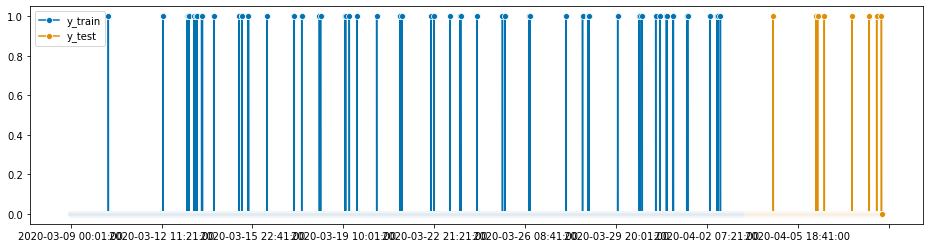

In [10]:
# Slipt test/train des données
y_train, y_test = temporal_train_test_split(filtered_df, test_size=1/6)
plot_series(y_train, y_test, labels=["y_train", "y_test",]);

                     value
2020-03-09 00:01:00    0.0
2020-03-09 00:02:00    0.0
2020-03-09 00:03:00    0.0
2020-03-09 00:04:00    0.0
2020-03-09 00:05:00    0.0
...                    ...
2020-04-03 19:56:00    0.0
2020-04-03 19:57:00    0.0
2020-04-03 19:58:00    0.0
2020-04-03 19:59:00    0.0
2020-04-03 20:00:00    0.0

[37200 rows x 1 columns]


C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\forecasting\base\_fh.py:533: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\forecasting\base\_fh.py:543: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:77: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
C:\Users\patrick.o

                     value
2020-04-03 20:01:00    0.0
2020-04-03 20:02:00    0.0
2020-04-03 20:03:00    0.0
2020-04-03 20:04:00    0.0
2020-04-03 20:05:00    0.0
2020-04-03 20:06:00    0.0
2020-04-03 20:07:00    0.0
2020-04-03 20:08:00    0.0
2020-04-03 20:09:00    0.0
2020-04-03 20:10:00    0.0
9685160488968.81


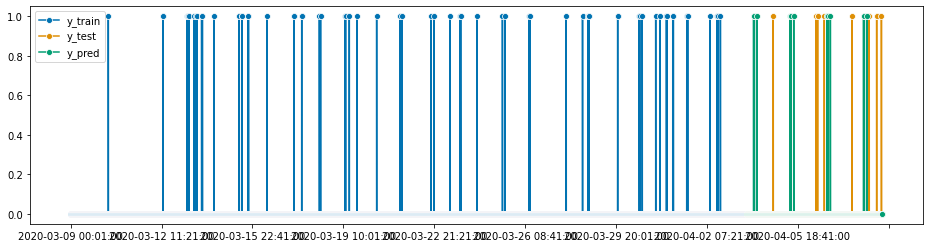

In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=24*12*7)
print(y_train)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)
print(y_pred[:10])
#y_pred.fillna(method='ffill', inplace=True)
#y_pred["value"] = y_pred.astype('int64')

# step 3: specifying the evaluation metric
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mape2 = MeanAbsolutePercentageError(symmetric=False)

# step 4: computing the forecast performance
print(mape2(y_test, y_pred))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [12]:
print(mape2(y_test, y_pred))
print(mae)
print(mape)

9685160488968.81
0.003763440860215054
9685160488968.81


In [13]:
y_pred.query('value>0.0')

,value
2020-04-04 02:01:00,1.0
2020-04-04 02:30:00,1.0
2020-04-04 02:45:00,1.0
2020-04-04 05:12:00,1.0
2020-04-05 11:37:00,1.0
2020-04-05 12:06:00,1.0
2020-04-05 12:21:00,1.0
2020-04-05 14:48:00,1.0
2020-04-06 21:13:00,1.0
2020-04-06 21:42:00,1.0


In [6]:
#Sauvegarde du modèle avec Pickle
filename = 'model_5896_bed_pressure.pkl'
pickle.dump(forecaster, open(filename, 'wb'))

In [7]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.arima import AutoARIMA

ensemble = EnsembleForecaster(forecasters = [("tbats", TBATS()),
                                             ("autoarima", AutoARIMA())],                         
                              aggfunc = "min")
ensemble.fit(y_train)
print(ensemble.forecasters_)

C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\forecasting\base\_fh.py:533: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\forecasting\base\_fh.py:543: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:77: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\patrick.olislaegers\AppData\Local\Programs\Python\Python39\lib\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
C:\Users\patrick.o

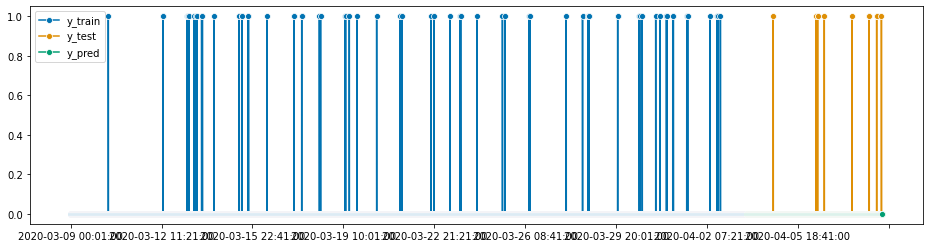

In [15]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA

from sktime.utils.plotting import plot_series


forecaster = AutoARIMA(start_p=1, start_q=1, max_p=3, max_q=3, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);